# BAyesian NEtwork
Burglary (B)
Earthquake(E)
Alarm(A)
David Calls(D)
Sophia calls(S)

In [1]:
!pip install pgmpy --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.9 MB/s eta 0:00:00


In [24]:
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.inference import VariableElimination
import seaborn as sns


In [4]:
model = BayesianNetwork([('Burglary', 'Alarm'),
                         ('Earthquake', 'Alarm'),
                         ('Alarm', 'DavidCalls'),
                         ('Alarm', 'SophiaCalls')])

In [6]:
graph = model.to_directed()

In [11]:
cpd_burglary = TabularCPD(variable='Burglary', variable_card=2,
                          values=[[0.999], [0.001]])  # P(Burglary = 0) = 0.999, P(Burglary = 1) = 0.001

# P(Earthquake)
cpd_earthquake = TabularCPD(variable='Earthquake', variable_card=2,
                            values=[[0.998], [0.002]])  # P(Earthquake = 0) = 0.998, P(Earthquake = 1) = 0.002

# P(Alarm | Burglary, Earthquake)
cpd_alarm = TabularCPD(variable='Alarm', variable_card=2,
                       values=[[0.99, 0.9, 0.9, 0.0],  # Alarm = 0
                               [0.01, 0.1, 0.1, 1.0]], # Alarm = 1
                       evidence=['Burglary', 'Earthquake'],
                       evidence_card=[2, 2])

# P(DavidCalls | Alarm)
cpd_david_calls = TabularCPD(variable='DavidCalls', variable_card=2,
                              values=[[0.95, 0.1],  # P(DavidCalls = 0 | Alarm = 0) = 0.95, P(DavidCalls = 1 | Alarm = 0) = 0.05
                                      [0.05, 0.9]],  # P(DavidCalls = 0 | Alarm = 1) = 0.05, P(DavidCalls = 1 | Alarm = 1) = 0.95
                              evidence=['Alarm'],
                              evidence_card=[2])

# P(SophiaCalls | Alarm)
cpd_sophia_calls = TabularCPD(variable='SophiaCalls', variable_card=2,
                               values=[[0.95, 0.2],  # P(SophiaCalls = 0 | Alarm = 0) = 0.95, P(SophiaCalls = 1 | Alarm = 0) = 0.05
                                       [0.05, 0.8]],  # P(SophiaCalls = 0 | Alarm = 1) = 0.05, P(SophiaCalls = 1 | Alarm = 1) = 0.95
                               evidence=['Alarm'],
                               evidence_card=[2])

In [14]:
model.add_cpds(cpd_burglary, cpd_earthquake, cpd_alarm, cpd_david_calls, cpd_sophia_calls)

# Check the model for consistency
model.check_model()

True

In [15]:
print(cpd_burglary)
print(cpd_earthquake)
print(cpd_alarm)
print(cpd_david_calls)
print(cpd_sophia_calls)

+-------------+-------+
| Burglary(0) | 0.999 |
+-------------+-------+
| Burglary(1) | 0.001 |
+-------------+-------+
+---------------+-------+
| Earthquake(0) | 0.998 |
+---------------+-------+
| Earthquake(1) | 0.002 |
+---------------+-------+
+------------+---------------+---------------+---------------+---------------+
| Burglary   | Burglary(0)   | Burglary(0)   | Burglary(1)   | Burglary(1)   |
+------------+---------------+---------------+---------------+---------------+
| Earthquake | Earthquake(0) | Earthquake(1) | Earthquake(0) | Earthquake(1) |
+------------+---------------+---------------+---------------+---------------+
| Alarm(0)   | 0.99          | 0.9           | 0.9           | 0.0           |
+------------+---------------+---------------+---------------+---------------+
| Alarm(1)   | 0.01          | 0.1           | 0.1           | 1.0           |
+------------+---------------+---------------+---------------+---------------+
+---------------+----------+----------+

In [18]:
inference = VariableElimination(model)
prob_alarm_given_david_calls = inference.query(variables=['Alarm'], evidence={'DavidCalls': 1})
print(prob_alarm_given_david_calls)

+----------+--------------+
| Alarm    |   phi(Alarm) |
+==========+==============+
| Alarm(0) |       0.8426 |
+----------+--------------+
| Alarm(1) |       0.1574 |
+----------+--------------+


In [29]:
!pip install graphviz  --quiet

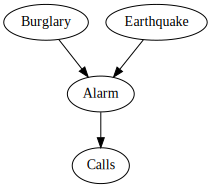

In [32]:
from graphviz import Digraph
from IPython.display import display

# Create a new directed graph
dot = Digraph()

# Add nodes (representing the random variables)
dot.node('B', 'Burglary')
dot.node('E', 'Earthquake')
dot.node('A', 'Alarm')
dot.node('C', 'Calls')

# Add directed edges (dependencies)
dot.edge('B', 'A')  # Burglary influences Alarm
dot.edge('E', 'A')  # Earthquake influences Alarm
dot.edge('A', 'C')  # Alarm influences Calls

# Display the graph directly
display(dot)

